## Assignment 4: Convolutional Neural Networks

In [1266]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

### Task 1

##### 1. Load and normalize CIFAR10

In [1267]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=False, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


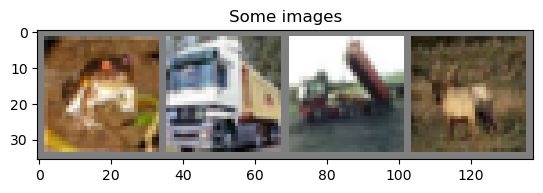

frog  truck truck deer 


In [1268]:
# functions to show an image


def imshow(img, title):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images), 'Some images')
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

##### 2. Define a Convolutional Neural Network

In [1269]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2, return_indices=True)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

        self.deconv2 = nn.ConvTranspose2d(16, 6, 5)
        self.deconv1 = nn.ConvTranspose2d(6, 3, 5)
        self.unpool = nn.MaxUnpool2d(2, 2)
        
    def forward(self, x):

        x, indices1 = self.pool(F.relu(self.conv1(x)))
        z1 = [x.clone(), indices1]
        x, indices2 = self.pool(F.relu(self.conv2(x)))        
        z2 = [x.clone(), indices2]
        
        deconv = x.clone()
        deconv = self.deconv2(F.relu(self.unpool(deconv, indices2)))
        deconv = self.deconv1(F.relu(self.unpool(deconv, indices1)))

        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x, deconv, z1, z2


net = Net()

##### 3. Define a Loss function and optimizer


In [1270]:
def criterion(outputs, labels, deconv_outputs, inputs) :
    criterion_ce = nn.CrossEntropyLoss()
    rec_loss = 0
    for i in range(3):
        rec_loss += torch.mean(torch.pow(inputs[:, i, :, :] - deconv_outputs[:, i, :, :], 2))
    rec_loss /= 3
    lambda_scalar = 1.2
    return criterion_ce(outputs, labels) + lambda_scalar*rec_loss

optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
# optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

##### 4. Train the network

In [1271]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs, deconv_outputs, _, _ = net(inputs)

        loss = criterion(outputs, labels, deconv_outputs, inputs)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.544
[1,  4000] loss: 2.074
[1,  6000] loss: 1.837
[1,  8000] loss: 1.724
[1, 10000] loss: 1.689
[1, 12000] loss: 1.624
[2,  2000] loss: 1.560
[2,  4000] loss: 1.551
[2,  6000] loss: 1.489
[2,  8000] loss: 1.450
[2, 10000] loss: 1.468
[2, 12000] loss: 1.426
Finished Training


In [1272]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

##### 5. Test the network on the test data

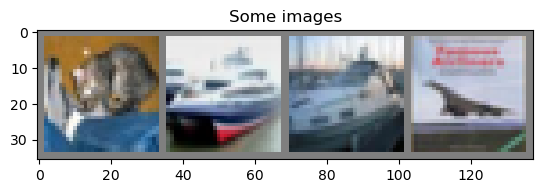

GroundTruth:  cat   ship  ship  plane


In [1273]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images), 'Some images')
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [1274]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [1275]:
outputs, deconv, _, _ = net(images)

In [1276]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  cat   car   car   ship 


In [1277]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs, _, _, _ = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 52 %


In [1278]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs, _, _, _ = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 56.1 %
Accuracy for class: car   is 71.9 %
Accuracy for class: bird  is 40.2 %
Accuracy for class: cat   is 45.0 %
Accuracy for class: deer  is 42.4 %
Accuracy for class: dog   is 27.5 %
Accuracy for class: frog  is 51.9 %
Accuracy for class: horse is 77.7 %
Accuracy for class: ship  is 63.6 %
Accuracy for class: truck is 53.4 %


### Task 2

torch.Size([4, 3, 32, 32])
torch.Size([4, 3, 32, 32])


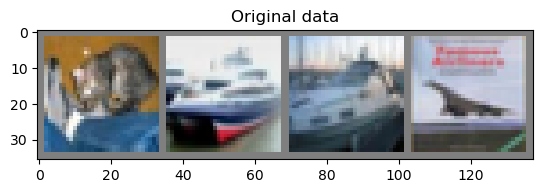

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


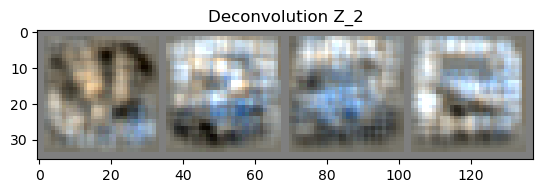

In [1279]:
dataiter = iter(testloader)
images, labels = next(dataiter)
_, deconv, _, _ = net(images)

print(images.shape)
print(deconv.shape)

imshow(torchvision.utils.make_grid(images), "Original data")
imshow(torchvision.utils.make_grid(deconv), "Deconvolution Z_2")

### Task 3

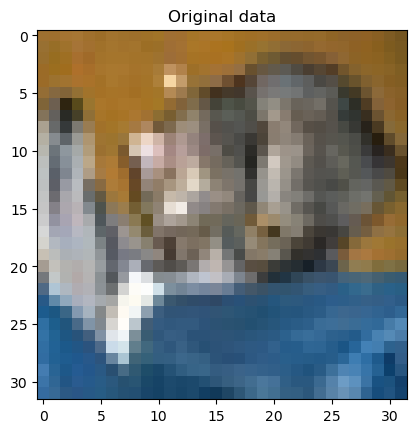

torch.Size([6, 14, 14])
torch.Size([16, 5, 5])


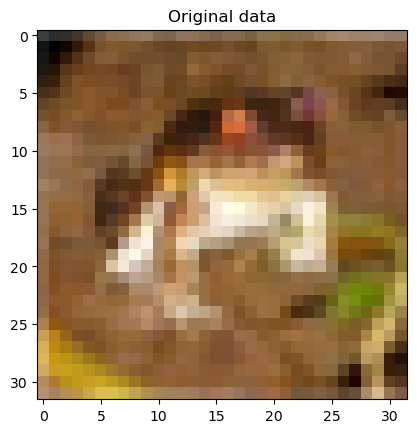

torch.Size([6, 14, 14])
torch.Size([16, 5, 5])


In [1280]:
dataiter_test = iter(testloader)
images_test, labels_test = next(dataiter_test)
imshow(torchvision.utils.make_grid(images_test[0]), "Original data")
_, _, z1_test, z2_test = net(images_test)

z1_test_indices = z1_test[1][1,:,:,:]
z2_test_indices = z2_test[1][1,:,:,:]

z1_test = z1_test[0][1,:,:,:]
z2_test = z2_test[0][1,:,:,:]

print((z1_test).shape)
print((z2_test).shape)

dataiter_train = iter(trainloader)
images_train, labels_train = next(dataiter_train)
imshow(torchvision.utils.make_grid(images_train[0]), "Original data")
_, _, z1_train, z2_train = net(images_train)

z1_train_indices = z1_train[1][1,:,:,:]
z2_train_indices = z2_train[1][1,:,:,:]

z1_train = z1_train[0][1,:,:,:]
z2_train = z2_train[0][1,:,:,:]

print((z1_train).shape)
print((z2_train).shape)



In [1281]:
def imshow2(img, title):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.detach().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    # plt.show()


In [1282]:
deconv2 = nn.ConvTranspose2d(16, 6, 5)
deconv1 = nn.ConvTranspose2d(6, 3, 5)
unpool = nn.MaxUnpool2d(2, 2)

In [1283]:
smaples = [
    [0, 1, 2, 3, 4],
    [0, 1, 2, 3, 5],
    [0, 1, 2, 4, 5],
    [0, 1, 3, 4, 5],
    [0, 2, 3, 4, 5],
    [1, 2, 3, 4, 5]
    ]

In [1284]:
reconstructed_images_z1_test = []
reconstructed_images_z2_test = []
reconstructed_images_z1_train = []
reconstructed_images_z2_train = []

In [1285]:
for i in range(len(smaples)) :
    z1_test_copy = z1_test.clone()
    z1_test_copy[smaples[i], :, :] = 0
    # reconstruct
    deconv = deconv1(F.relu(unpool(z1_test_copy, z1_test_indices)))
    reconstructed_images_z1_test.append(deconv)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


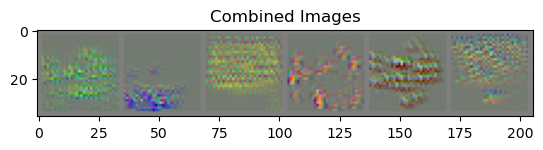

In [1286]:
# Create a combined grid image
grid_images = []
for i in range(len(reconstructed_images_z1_test)):
    img = torchvision.utils.make_grid(reconstructed_images_z1_test[i])
    grid_images.append(img)

# Create a single plot to display all images
combined_image = torchvision.utils.make_grid(grid_images, nrow=len(reconstructed_images_z1_test))

# Display the combined image
imshow2(combined_image, "Combined Images")

In [1287]:
for i in range(len(smaples)) :
    z1_train_copy = z1_train.clone()
    z1_train_copy[smaples[i], :, :] = 0
    # reconstruct
    deconv = deconv1(F.relu(unpool(z1_train_copy, z1_train_indices)))
    reconstructed_images_z1_train.append(deconv)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


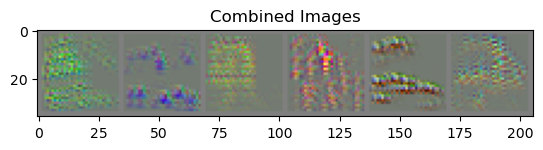

In [1288]:
grid_images = []
for i in range(len(reconstructed_images_z1_train)):
    img = torchvision.utils.make_grid(reconstructed_images_z1_train[i])
    grid_images.append(img)

# Create a single plot to display all images
combined_image = torchvision.utils.make_grid(grid_images, nrow=len(reconstructed_images_z1_train))

# Display the combined image
imshow2(combined_image, "Combined Images")

In [1289]:
smaples = [
    [0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
    [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15],
    [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
    ]

In [1290]:
for i in range(len(smaples)) :
    z2_test_copy = z2_test.clone()
    z2_test_copy[smaples[i], :, :] = 0
    # reconstruct
    deconv = deconv2(F.relu(unpool(z2_test_copy, z2_test_indices)))
    deconv = deconv1(F.relu(unpool(deconv, z1_test_indices)))
    reconstructed_images_z2_test.append(deconv)

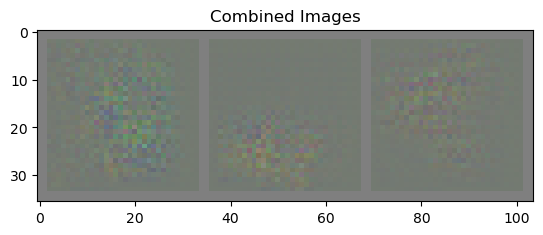

In [1291]:
# Create a combined grid image
grid_images = []
for i in range(len(reconstructed_images_z2_test)):
    img = torchvision.utils.make_grid(reconstructed_images_z2_test[i])
    grid_images.append(img)

# Create a single plot to display all images
combined_image = torchvision.utils.make_grid(grid_images, nrow=len(reconstructed_images_z2_test))

# Display the combined image
imshow2(combined_image, "Combined Images")

In [1292]:
for i in range(len(smaples)) :
    z2_train_copy = z2_train.clone()
    z2_train_copy[smaples[i], :, :] = 0
    # reconstruct
    deconv = deconv2(F.relu(unpool(z2_train_copy, z2_train_indices)))
    deconv = deconv1(F.relu(unpool(deconv, z1_train_indices)))
    reconstructed_images_z2_train.append(deconv)

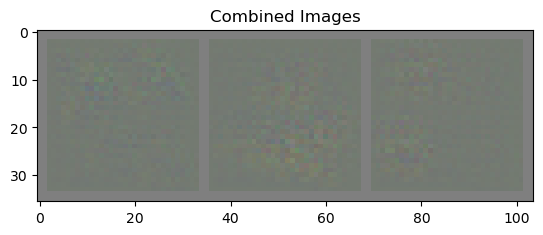

In [1293]:
grid_images = []
for i in range(len(reconstructed_images_z2_train)):
    img = torchvision.utils.make_grid(reconstructed_images_z2_train[i])
    grid_images.append(img)

# Create a single plot to display all images
combined_image = torchvision.utils.make_grid(grid_images, nrow=len(reconstructed_images_z2_train))

# Display the combined image
imshow2(combined_image, "Combined Images")